In [64]:
import numpy as np
import networkx as nx
from scipy.optimize import minimize
import scipy.linalg as LA    
import matplotlib.pyplot as plt 
import cma 
import ipdb

#number of modes in covariance matrix
n_modes = 4

#mode index
#generates a comb of modes centered on index 0
n_index = np.arange(n_modes) - n_modes//2
print("mode_index",n_index)

# #JPA resonance (MHz)
omega_0p = np.array([ 2*np.pi*4.3e3 ])

#dissipation rates (MHZ)
gamma_int = 2*np.pi*20e-3 * np.ones_like(omega_0p)
gamma_ext = 2*np.pi*300* np.ones_like(omega_0p)
gamma_p = gamma_ext 

#pump_frequencies (MHz)
p1_freq = 2*2*np.pi*4.3023e3
p2_freq = 2*2*np.pi*4.2977e3

#mode frequencies, set up frequency comb
center_comb_freq = (p2_freq + p1_freq)/4
comb_det = np.abs(p2_freq - p1_freq)/4
comb_freqs = center_comb_freq + n_index*comb_det
print("center freq", center_comb_freq)
print("comb freqs", comb_freqs)

#-----------set pump positions and strengths -------------------
#pump mode positions, enter a numpy array
#pump_position = np.array([-1.0,1.0])

#enter pump amp and phase (enter a complex number)
#effective pump amplitude
phi1 = 4e-3*np.exp(0)
phi2 = 4e-3*np.exp(0)
phi3 = 4e-3*np.exp(0)
phi4 = 4e-3*np.exp(0)

#bias point
phi_DC = 0.6*np.pi

mode_index [-2 -1  0  1]
center freq 27017.69682087222
comb freqs [26988.79416846 27003.24549467 27017.69682087 27032.14814708]


In [65]:
def get_cov_matrix(pump_amplitudes):
    
    if len(pump_amplitudes) != 2*n_modes - 1:
        sys.exit("Wrong length of pump_amplitudes. It is " + str(len(pump_amplitudes)) + " but should be " + str(2*n_modes - 1))
    
    # get pump_position and pump_strength, 
    # create list of nonzero pump amplitudes
    pump_strength = pump_amplitudes[np.nonzero(pump_amplitudes)]
    
    all_pump_pos = np.arange(np.min(n_index), np.max(n_index) + 0.5, 0.5)
    # create list of pump positions where the pump amplitude is nonzero
    pump_position = all_pump_pos[np.nonzero(pump_amplitudes)]

    #print("pump_pos", pump_position)

    M = np.zeros(( n_modes*2, n_modes*2 ), dtype = complex)
    
    for i, s in enumerate(n_index):
    
        idler_positions = 2*pump_position - s
    
        if len(omega_0p) == 1:
            omega_0 = omega_0p[0]
            gamma = gamma_p[0]
            K = np.identity(2*n_modes)*np.sqrt(gamma_ext)
            K_loss = np.identity(2*n_modes)*np.sqrt(gamma_int)
        else:
            omega_0 = omega_0p[i]
            gamma = gamma_p[i]
            K = np.block( [[ np.diag(np.sqrt(gamma_ext)), np.zeros((n_modes, n_modes)) ], 
                       [ np.zeros((n_modes, n_modes)), np.diag(np.sqrt(gamma_ext)) ]] )
            K_loss = np.block( [[ np.diag(np.sqrt(gamma_int)), np.zeros((n_modes, n_modes)) ], 
                            [ np.zeros((n_modes, n_modes)), np.diag(np.sqrt(gamma_int)) ]] )

    
        #constructing the mode coupling matrix M
        for pos, i1 in enumerate(idler_positions):
            if np.any(n_index == i1):
                j = np.where(n_index == i1)[0][0]
                #coupling strength given below
                #coupling depends on system, for SAW see the off-diagonal terms below eq. S35 in SAW supplementary
                #should be much smaller than the linewidth
                conver_rate = -omega_0/4*np.tan(phi_DC)*pump_strength[pos]*np.pi #for JPA
                #conver_rate = -pump_strength[pos]
                M[i,j+n_modes] = conver_rate
                M[i+n_modes, j] = -np.conjugate(conver_rate)
        


        diag_val = comb_freqs[i] - omega_0 + 1j*gamma/2
        diag_val_conj = -np.conjugate(diag_val)
    
        M[i, i] = diag_val
        M[i+n_modes, i+n_modes] = diag_val_conj


    #calculating the scattering matrix
    M_inv = np.linalg.inv(M)
    S = 1j*K.dot(M_inv).dot(K) - np.identity(2*n_modes)
    #for the internal loss channel, we need a second term
    Sp = 1j*K.dot(M_inv).dot(K_loss)


    # ----------------------- calculate the covariance matrix ----------------
    #convert scattering basis to the x, p basis
    #the vector ordering becomes (x1, x2, ...., p1,p2,....)
    X = np.zeros_like(S, dtype = complex)
    for ii in range(n_modes):
        X[ii, ii], X[ii, ii+n_modes] = np.ones(2)
        X[ii+n_modes, ii] = -1j
        X[ii+n_modes, ii+n_modes] = 1j
    
    #transform scattering matrix
    X_inv = np.linalg.inv(X)
    S_xp = X.dot(S).dot(X_inv)
    Sp_xp = X.dot(Sp).dot(X_inv)

    #check if it is symplectic
    symp = np.block( [ [np.zeros((n_modes, n_modes)), np.identity(n_modes)], [-1*np.identity(n_modes), np.zeros((n_modes, n_modes))] ] )

    symp2 = S_xp.dot(symp).dot(np.transpose(S_xp))

    result = np.all(np.round( np.real(symp2) , 3) == symp )
    #print(' The transformation is symplectic: ' + str(result) )

    # calculate resulting covariance matrix
    #input noise:
    n_noise = 0
    V_input = (2*n_noise + 1)*np.identity(2*n_modes)
    #noise from loss channel, we can assume it is at the same temperature as the input channel
    V_loss = V_input
    #output statistics
    noise_from_loss_channel = np.real(Sp_xp.dot(V_loss).dot( np.transpose(Sp_xp) ))
    V_output = np.real(S_xp.dot(V_input).dot( np.transpose(S_xp) )) + noise_from_loss_channel

    #re-order V_output into the (x1, p1, x2, p2...) ordering basis
    V_out_reorder = np.zeros_like(V_output)
    V_out_reorder[0:2*n_modes:2, 0:2*n_modes:2] = V_output[0:n_modes, 0:n_modes]
    V_out_reorder[1:2*n_modes:2, 1:2*n_modes:2] = V_output[n_modes:, n_modes:]
    V_out_reorder[0:2*n_modes:2, 1:2*n_modes:2] = V_output[0:n_modes, n_modes:]
    V_out_reorder[1:2*n_modes:2, 0:2*n_modes:2] = V_output[n_modes:, 0:n_modes] 

    return M, V_out_reorder

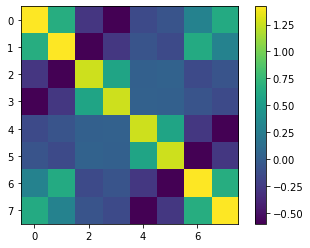

In [66]:
pump_occupation = [0,0,30,30,30,0,0]

pump_amplitudes = np.multiply(pump_occupation, phi1)

M, V_out_example = get_cov_matrix(pump_amplitudes)
plt.imshow(V_out_example);
plt.colorbar();

In [87]:
def optimizationfunction(pump_geuss):
    pump_test=np.multiply(pump_geuss, phi1)
    #Insert the covariance matrix for [0,0,30,30,30,0,0] as the optimal case:
    M1, V_output= get_cov_matrix(pump_test)
    V_optimal=V_out_example
    diff=np.linalg.norm(V_output-V_optimal)
    return diff

In [88]:
def optimizer(pump_assumption):
    #es = cma.CMAEvolutionStrategy(pump_assumption, 0.2,{'bounds': [[0], [50]]})
    #es.optimize(optimizationfunction)
    #out=es.result_pretty()
    #pump_close=out[0]
    
    
    #out=minimize(optimizationfunction,pump_assumption,method='Nelder-Mead')
    #pump_close=out.x
    
    
    out = cma.fmin(optimizationfunction, pump_assumption, 0.2, {'bounds':[0,50]})
    pump_close=out[0]
    return pump_close

In [92]:
#pump_assumption=np.zeros_like(pump_occupation)
pump_assumption=[0,0,29,29,29,0,0]

pump_optimized0=optimizer(pump_assumption)

pump_optimized = np.multiply(pump_optimized0, phi1)

M1, V_optimized=get_cov_matrix(pump_optimized)

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 7 (seed=868553, Wed Apr 13 11:10:32 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.314148713028661e-01 1.0e+00 1.96e-01  2e-01  2e-01 0:00.0
    2     18 1.359645949667118e-01 1.3e+00 1.93e-01  2e-01  2e-01 0:00.0
    3     27 1.132990694572524e-01 1.2e+00 1.78e-01  2e-01  2e-01 0:00.0
  100    900 1.682670850132715e-03 1.7e+01 3.05e-02  1e-02  2e-02 0:00.7
  200   1800 5.252681613343690e-05 8.8e+01 3.64e-03  4e-04  2e-03 0:01.4
  300   2700 2.234048830242976e-06 4.6e+02 1.02e-03  2e-05  4e-04 0:02.1
  400   3600 2.598024612695685e-07 1.1e+03 1.03e-03  2e-06  2e-04 0:02.8
  500   4500 1.196446482464912e-08 4.9e+03 2.89e-04  9e-08  3e-05 0:03.5
  600   5400 6.784013870694393e-10 2.2e+04 6.54e-05  3e-09  5e-06 0:04.1
  700   6300 2.403925110216427e-10 5.8e+04 1.75e-04  2e-09  7e-06 0:04.8
NOTE (module=cma, iteration=797):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
c

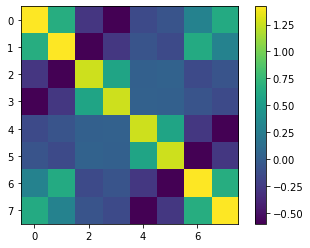

In [93]:
plt.imshow(V_optimized)
# ax.set_title('weighted covariance matrix ON')
plt.colorbar()

In [94]:
print(pump_optimized0)

[5.64193749e-11 8.29020741e-11 3.00000000e+01 3.00000000e+01
 3.00000000e+01 4.53328886e-11 2.04498095e-12]
